# Digital Image Processing - HW11 - 98722278 - Mohammad Doosti Lakhani
In this notebook, I have solved the assignment's problems which are as follows:
1. Define and compare Semantic Segmentation, Object Detection and Instance Segmentation
    1. Semantic Segmentation
    2. Object Detection
    3. Instance Segmentation
    4. Final Words
2. Compare *RCNN*, *Fast RCNN* and *Faster RCNN*
    1. RCNN
    2. Fast RCNN
    3. Faster RCNN
3. Write a [Matching Template](https://docs.opencv.org/2.4/modules/imgproc/doc/object_detection.html?highlight=matchtemplate) algorithm to read car plate numbers

## 1 Compare Semantic Segmentation, Object Detection and Instance Segmentation

1. *Semantic Segmenation* simply is the pixel-wise image classification which means, in a given image, each pixel have to be labeled to its coressponding class. In semantic segmenation, model is not aware of objects.

Here is image of the PSPNet, state of the art model of semantic segmentation:

![pspnet](wiki/pspnet.png)

2. *Object Detection* is similar to the semantic segmentation but the difference is that only indicating a bounding box around the detected object would be enough (not pixel wise), but still objects in a image need to be detected. Note that if there are multiple instance of same object, still the bounding boxes and their labels must be distinct. So in simple words, classification and localization is done by object detection.

![object detection](wiki/objectdetection.png)

3. *Instance Segmentation* is similar to semantic segmenatation in term of pixel-wise classification but the major difference is that in semantic segmenation model is not aware of object or multiple instance of a same class, but in instance segmenatation, similar to object detection, all instance of same object need to be classified BUT pixel-wise.

![instance segmentation](wiki/instancesegmentation.png)

## 2 Compare *RCNN*, *Fast RCNN* and *Faster RCNN*
1. RCNN
2. Fast RCNN
3. Faster RCNN

### 2.A RCNN
RCNN consists of two major components, a CNN and a Region extractor.

Firstly, it uses selective search to identify a rational number of bounding boxes as the regions of interests (RoI). Seconly, It uses these extracted regions as input to a pretrained CNN network for classification separately.

![rcnn arch](wiki/rcnn1.png)

Here are the main steps of RCNN:

1. The CNN model must have been pretrained for a image classification tast such as VGG on ImageNet dataset
2. It uses RoI that is hardcoded and do not need to be optimized.
3. All extracted RoIs will be resized as the size of pretrained CNN
4. Fine tune the CNN model w.r.t. classes. But a point need to be mentioned is that as most of the proposed RoIs are negative samples, we need to oversample positive RoIs while fine tuning CNN model
5. Now we use CNN model to extract useful features from RoIs which in case of VGG it would be 4096 features
6. A binary SVM classfier (each class a distinct binary SVM) uses extracted features from CNN to classify the image
7. To find optimal localization, a regression model is used to to correct predicted boxes

![rcnn top down](wiki/rcnn2.png)

The approach which Bounding Box Regressor takes:
The BBregressor uses predicted bounding box and ground truth to map in scale-variant manner. Also it updates the height and width by learning log-scale transformation. They used SSE loss plus L2 regularization to optimize this regressor.

![rcnn bb regressor](wiki/rcnn3.png)

One important indication of RCNN is that they used Non-max suppression to confluence overlapping bounding boxes into a single one which represents more score than the others.

![nms](wiki/nms.png)

But this model has a lot of problems:
1. selective search has been used to obtain RoIs which means it is not learnable and slow
2. For each extracted RoI, CNN need to be called which makes the algorithm super slow (about 47 sec per image)
3. All model are separate, regressor, CNN and SVM!

### 2.B Fast RCNN
What was the main problem of RCNN? Speed!

In fast RCNN, three distinct models joint each other to share results. This model instead of using CNN independently for each extracted region, it combines it with extraction part and only uses CNN once per image and RoI is based on the feature of CNN. In other words, first we take CNN, then RoI of feature vector generated from CNN and resize them to have same size for all and finally a stacked neural nets are the structure.

![fast rcnn](wiki/fast1.png)

This model to obtain the aforementioned approach, proposed a type of max pooling called *RoI Pooling*. This kind of pooling, decreases the size of a feature image with region of interest to a smaller feature image. It first make a grid with size of say hxw, then take max pooling in each grid.

![roi pooling](wiki/fast2.png)

Most of the steps are same with RCNN so here are the main ones:
1. The last pooling layer of CNN has been changed from max pooling to RoI pooling. RoI pooling outputs fixed length feature vectors that can be used for prediction perposes.
2. Last fully connected layer also needs to be changed to support non-interest regions (background- non of our classes)
3. This model also outputs two factors, first, score of classifcation for each RoI, second, the bounding box value for regressor.
4. Smooth L1 loss has been used for computing error of bounding boxes. The overall loss function is sum of Smooth L1 and softmax for classfication part.

The model has got much more speed since computation of models have been shared and only once the CNN has been used instead of using it for each RoI in each image. (N image=N*2000 CNN calls reduced to 1 CNN call!)

![time compare rcnn fast rcnn](wiki/fast3.png)

A big bottleneck can be seen in above image is that when using selective search part to obtain RoIs, it almost take 2 seconds which is dominating all other part of the network in fast RCNN. So you can guess what is going to be in Faster RCNN!

![fast rcnn arch top down](wiki/fast4.png)

### 2.C Faster RCNN
The last line in Fast RCNN section told us that almost all delay in our network is because of hardcoded part, the selective search for extracting RoIs. So in simple words, Faster RCNN removed that part and created a separate CNN model to extract RoIs from the given feature vector and that is why we have an end-to-end network which is enormously faster than hardcoded algorithms. 

![faster RCNN](wiki/faster1.png)

How the model works:
1. Like always we need a pretrained CNN model
2. Fine tune Region Proposal Network (the true heir of selective search!) where has been initialized using the CNN pretrained model. RPN, slides over the feature image obtained from pretrained CNN model, at each step of sliding window of RPN, multiple region of various scale and ratios are predicted simultaneously and the anchor is combination of these predicted values. For instance, 3 scale, 3 ratios give us 9 anchor boxes.

![RPN](wiki/faster4.png)

3. Reshape extracted regions by RoI pooling layer
3. Train FAST RCNN using currently proposed RoIs by RPN.
4. Use FAST RCNN network which has been trained in previous step for initializing RPN, and only fine tune layers specifictly for RPN as RPN and predictor have common layers.
5. Freeze RPN and fine tune layers uniquely of the Fast RCNN (exclude common layers).

![faster RCNN top down arch](wiki/faster2.png)

In this model aslo a value of score that current predicted anchor is indicating an object plus attribute of the bounding box is the inputs of loss function where loss function are same with Fast RCNN.

This approach enabled model to skip the bottleneck of using selective search. Here is the time and performance imporovemenets:

![faster RCNN time consumption](wiki/faster3.png)




## 3 Car Plate Reader via Matching Template
1. Libraries
1. First Approach
2. Second Approach (didn't finished!)

### 3.A Libraries

In [172]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import match_template
from sklearn.cluster import DBSCAN

%matplotlib inline

### 3.B First Approach
Reading each character using a threshold distinctly from other characters, then finding their locations using clustering techniques such as DBSCAN instead of non-max suppression using IoU.
1. Setting Hyper parameters
2. Preprocessing image
3. Iterating over and preprocessing templates

#### 3.B.a Setting hyper parameters

In [ ]:
NUMBER_COUNTS = 9

rotation_angles = [-20, -15, -10, -5, 0, 5, 10, 15, 20]
scale_percents = [10, 20, 30, 40, 50, 70, 80, 90, 100, 110]
threshold = 0.7

#### 3.B.b Preprocessing Image

In [ ]:
img = cv2.imread('plates/Plate5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(_, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#### 3.B.c Iterating over and preprocessing templates

[-1.  2.  5. -1.  2.  2.  6.  1. -1.]


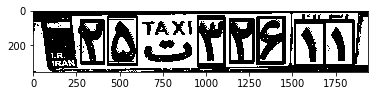

In [292]:
num_pos = np.ones(NUMBER_COUNTS) * -1

for template_number in range(10):
    template = cv2.imread('Templates/'+str(template_number)+'.jpg')
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    (_, template) = cv2.threshold(template, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    for scale in scale_percents:
        for angle in rotation_angles:
            # resize
            width = int(template.shape[1] * scale / 100)
            height = int(template.shape[0] * scale / 100)
            dim = (width, height)
            temp = cv2.resize(template, dim, interpolation = cv2.INTER_AREA)
            if temp.shape[0] > img.shape[0] or temp.shape[1] > img.shape[1]:
                continue
            # rotate
            temp_center = tuple(np.array(temp.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(temp_center, angle, 1.0)
            result = cv2.warpAffine(temp, rot_mat, temp.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(255,255,255))
            w, h = temp.shape[::-1]
            
            # template matching
            res = cv2.matchTemplate(img, temp, cv2.TM_CCOEFF_NORMED)
            loc = np.where( res >= threshold)
            if not loc[1].shape[0] == 0:
                dbscan = DBSCAN(eps=3)
                dbscan.fit(loc[1].reshape(-1, 1))
                for cluster in range(dbscan.labels_.max()+1):
                    idx = loc[1][(dbscan.labels_ == cluster).nonzero()[0]].mean() // (img.shape[1] / NUMBER_COUNTS)
                    num_pos[int(idx)] = template_number
                    # here use 'res' and 'idx' to get maximum probability then apply template number with max res value
                for pt in zip(*loc[::-1]):
                    cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)
                cv2.imwrite('res.png', img)
if num_pos[0] != -1:
    num_pos[1] = num_pos[0]
    num_pos[0] = -1
plt.imshow(img, cmap='gray')
print(num_pos)

### 3.C Second Approach
Gathering all scores of all preprocessed templates then taking max over them and their args. Using non-max suppression to localize maximums.
1. Setting Hyper parameters
2. Preprocess template
2. Preprocessing image
3. Iterating over templates
4. NMS

#### 3.C.a Setting hyper parameters

In [193]:
NUMBER_COUNTS = 9
TEMPLATE_COUNTS = 10

rotation_angles = [-15, -10, -5, 0, 5, 10, 15]
scale_percents = [10, 20, 30, 40, 50, 70, 80, 90, 100, 110]

threshold = 0.7

#### 3.C.b Preprocess templates

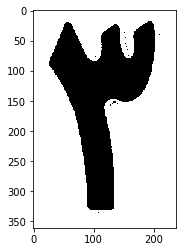

In [194]:
templates = []
for template_number in range(10):
    template = cv2.imread('Templates/'+str(template_number)+'.jpg')
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    (_, template) = cv2.threshold(template, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    templates.append(template)

plt.imshow(templates[3], cmap='gray')

#### 3.C.c Preprocess image

In [307]:
img = cv2.imread('plates/Plate2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(_, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#### 3.C.d Iterating over templates

In [308]:
probs = np.ones((img.shape[0], img.shape[1], TEMPLATE_COUNTS)) * -1
for t_idx, template in enumerate(templates):
    template_results = []
    template_whc = []
    for scale in scale_percents:
        for angle in rotation_angles:
            # resize
            width = int(template.shape[1] * scale / 100)
            height = int(template.shape[0] * scale / 100)
            dim = (width, height)
            temp = cv2.resize(template, dim, interpolation = cv2.INTER_AREA)
            if temp.shape[0] > img.shape[0] or temp.shape[1] > img.shape[1]:
                continue
            # rotate
            temp_center = tuple(np.array(temp.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(temp_center, angle, 1.0)
            temp = cv2.warpAffine(temp, rot_mat, temp.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(0,0,0))
            w, h = temp.shape[::-1]
            
            # template matching
            res = match_template(img, temp, True)
            template_results.append(res)
            template_whc.append((w, h, temp_center[0], temp_center[1]))
    
    template_probs = np.ones((img.shape[0], img.shape[1], len(template_results))) *-1
    template_whc_np = np.zeros((len(template_whc), 4))
    for idx, r in enumerate(template_results):
        template_probs[:,:,idx] = r
        template_whc_np[idx,:] = template_whc[idx]
    probs[:,:,t_idx] = np.max(template_probs, axis=2)
    indices = np.argmax(template_probs, axis=2)
    whc = template_whc_np[indices]

#### 3.C.e NMS (I failed this step because of lack of time!)

In [280]:
thresh = 0.5
dets = whc.reshape(-1, 4)
scores = np.max(probs, axis=2).reshape(-1, )
w = dets[:, 0]
h = dets[:, 1]
cx = dets[:, 2]
cy = dets[:, 3]
x1 = cx-w//2
y1 = cy-h//2
x2 = cx+w//2
y2 = cy+h//2

areas = (x2 - x1 + 1) * (y2 - y1 + 1)
order = scores.argsort()[::-1]

keep = []
while order.size > 0:
    i = order[0]
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)

    inds = np.where(ovr <= thresh)[0]
    order = order[inds + 1]

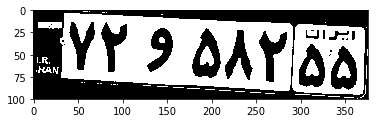

In [309]:
plt.imshow(img, cmap='gray')

location of max:  (array([39], dtype=int64), array([232], dtype=int64))


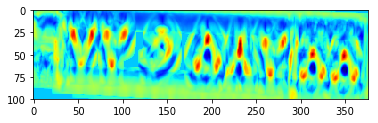

In [315]:
number = 8
plt.imshow(probs[:,:,number], cmap='jet')
print('location of max: ',np.where(probs[:,:,number] == np.max(probs[:,:,number])))